In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import time

## Data Loading

In [4]:
train_path = 'KDDTrain+.arff'
test_path = 'KDDTest+.arff'

train_arff = arff.loadarff(train_path)
test_arff = arff.loadarff(test_path)

train_df = pd.DataFrame(train_arff[0])
test_df = pd.DataFrame(test_arff[0])

for col in train_df.columns:
  if train_df[col].dtype == 'object':
    train_df[col] = train_df[col].str.decode('utf-8')

for col in test_df.columns:
  if test_df[col].dtype == 'object':
    test_df[col] = test_df[col].str.decode('utf-8')

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
# Save train_df to CSV
train_csv_path = 'KDDTrain+.csv'
train_df.to_csv(train_csv_path, index=False)

# Save test_df to CSV
test_csv_path = 'KDDTest+.csv'
test_df.to_csv(test_csv_path, index=False)

print("DataFrames saved as CSV files.")

DataFrames saved as CSV files.


### Preprocess the data

In [ ]:
def preprocess_data(X_train, X_test):
    categorical_features = ['protocol_type', 'service', 'flag']
    numerical_features = X_train.drop(columns=categorical_features).columns

    # Preprocessor for handling both categorical and numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_test_processed

X = train_df.drop('class', axis=1)
y = train_df['class']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train, x_test = preprocess_data(x_train, x_test)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)


## Comparitive analysis of Classic ML Models
 * Decision Tree
 * Random Forest
 * SVM (Support Vector Machine)
 * KNN (K Nearest Neighbours)
 * XGBoost
 * AdaBoost

| Model          | Accuracy | Precision | Recall | F1-Score | Computation Time (s) |
|----------------|----------|-----------|--------|----------|-----------------------|
| Decision Tree  | 0.9984   | 0.9984    | 0.9984 | 0.9984   | 2.1330                |
| Random Forest  | 0.9987   | 0.9987    | 0.9987 | 0.9987   | 15.0116               |
| SVM            | 0.9918   | 0.9918    | 0.9918 | 0.9918   | 90.4185               |
| KNN            | 0.9957   | 0.9957    | 0.9957 | 0.9957   | 38.9931               |
| XGBoost        | 0.9991   | 0.9991    | 0.9991 | 0.9991   | 5.9451                |
| AdaBoost       | 0.9882   | 0.9882    | 0.9882 | 0.9882   | 14.8327               |

### Key Observations:
- **XGBoost** achieved the highest accuracy (0.9991) while also having a relatively low computation time (3.45 seconds).
- **Random Forest** also performed very well, with slightly lower accuracy than XGBoost but significantly higher computation time (11.63 seconds).
- **SVM** had good accuracy (0.9918) but took the longest time to compute (96.66 seconds), making it less efficient for larger datasets.
- **Decision Tree** performed well with quick computation time (1.93 seconds), but it was slightly less accurate than XGBoost and Random Forest.

In [ ]:
# Defining models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    results[name] = {
        "Accuracy": accuracy,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score'],
        "Computation Time": elapsed_time
    }

# Display results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Decision Tree:
  Accuracy: 0.9984
  Precision: 0.9984
  Recall: 0.9984
  F1-Score: 0.9984
  Computation Time: 2.1330
Random Forest:
  Accuracy: 0.9987
  Precision: 0.9987
  Recall: 0.9987
  F1-Score: 0.9987
  Computation Time: 15.0116
SVM:
  Accuracy: 0.9918
  Precision: 0.9918
  Recall: 0.9918
  F1-Score: 0.9918
  Computation Time: 90.4185
KNN:
  Accuracy: 0.9957
  Precision: 0.9957
  Recall: 0.9957
  F1-Score: 0.9957
  Computation Time: 38.9931
XGBoost:
  Accuracy: 0.9991
  Precision: 0.9991
  Recall: 0.9991
  F1-Score: 0.9991
  Computation Time: 5.9451
AdaBoost:
  Accuracy: 0.9882
  Precision: 0.9882
  Recall: 0.9882
  F1-Score: 0.9882
  Computation Time: 14.8327


## Dataset Modification

Since the dataset does not explicitly mention the attack type, We will have to manually add it to the dataset. Here's the automation code.

In [2]:
from scipy.io import arff
import pandas as pd

# Load the dataset
train_path = 'KDDTrain+.arff'
test_path = 'KDDTest+.arff'

train_arff = arff.loadarff(train_path)
test_arff = arff.loadarff(test_path)

train_df = pd.DataFrame(train_arff[0])
test_df = pd.DataFrame(test_arff[0])

# Decode bytes to strings for categorical columns
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].str.decode('utf-8')

for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].str.decode('utf-8')

# Apply attack labeling function
def label_attack_type(row):
    # Attack labeling rules (as provided previously)
    if row['protocol_type'] == 'icmp' and row['service'] in ['eco_i', 'ecr_i'] and row['flag'] == 'SF' and row['dst_host_same_srv_rate'] > 0.5:
        return 'Smurf'
    elif row['protocol_type'] == 'tcp' and row['flag'] == 'S0' and (row['serror_rate'] > 0.5 or row['srv_serror_rate'] > 0.5):
        return 'Neptune'
    elif row['protocol_type'] == 'tcp' and row['diff_srv_rate'] > 0.5 and row['flag'] in ['SF', 'S1']:
        return 'Nmap'
    elif row['srv_count'] > 10 and row['dst_host_srv_count'] > 10 and row['protocol_type'] in ['tcp', 'icmp'] and row['flag'] in ['SF', 'S1']:
        return 'Satan'
    elif row['protocol_type'] == 'tcp' and row['service'] == 'private' and row['dst_host_count'] > 200 and row['flag'] == 'REJ':
        return 'Portsweep'
    elif row['protocol_type'] == 'icmp' and row['service'] == 'other' and row['serror_rate'] < 0.1:
        return 'Ping_of_Death'
    elif row['service'] in ['ftp', 'telnet'] and row['num_failed_logins'] > 0 and row['protocol_type'] == 'tcp':
        return 'Guess_password'
    elif row['service'] == 'ftp' and row['num_file_creations'] > 0 and row['num_failed_logins'] > 0:
        return 'FTP_write'
    elif row['root_shell'] > 0 or row['num_root'] > 0 or row['num_shells'] > 0 or row['su_attempted'] > 0:
        return 'Rootkit'
    elif (row['src_bytes'] > 1000 or row['dst_bytes'] > 1000) and row['flag'] in ['S0', 'REJ'] and (row['serror_rate'] > 0.5 or row['dst_host_serror_rate'] > 0.5):
        return 'DoS'
    elif (row['count'] > 10 or row['srv_count'] > 10) and row['flag'] in ['S1', 'S3', 'SF'] and row['protocol_type'] in ['tcp', 'icmp']:
        return 'Probe'
    elif (row['num_failed_logins'] > 0 or row['is_guest_login'] == '1') and row['service'] in ['ftp', 'telnet', 'ssh'] and (row['num_access_files'] > 0 or row['num_file_creations'] > 0):
        return 'R2L'
    elif (row['root_shell'] > 0 or row['su_attempted'] > 0) and (row['num_root'] > 0 or row['num_file_creations'] > 0 or row['num_shells'] > 0):
        return 'U2R'
    else:
        return 'Other'

# Apply the labeling function to training and test datasets
train_df['attack_type'] = train_df.apply(lambda row: label_attack_type(row) if row['class'] == 'anomaly' else 'normal', axis=1)
test_df['attack_type'] = test_df.apply(lambda row: label_attack_type(row) if row['class'] == 'anomaly' else 'normal', axis=1)

# Encode categorical columns
categorical_columns = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
train_df_encoded = pd.get_dummies(train_df, columns=categorical_columns)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_columns)

# Align columns between train and test sets
train_df_encoded, test_df_encoded = train_df_encoded.align(test_df_encoded, join='left', axis=1, fill_value=0)

In [3]:
from sklearn.model_selection import train_test_split

# Prepare features and labels
X = train_df_encoded.drop(columns=['class', 'attack_type'])
y = train_df_encoded['class'].apply(lambda x: 0 if x == 'normal' else 1)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Prepare test data
X_test = test_df_encoded.drop(columns=['class', 'attack_type'])
y_test = test_df_encoded['class'].apply(lambda x: 0 if x == 'normal' else 1)

# Display shapes of datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (100778, 126)
y_train shape: (100778,)
X_val shape: (25195, 126)
y_val shape: (25195,)
X_test shape: (22544, 126)
y_test shape: (22544,)


In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize and train the XGBoost model without tuning
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = model.predict(X_val)

# Evaluate on validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Predict on test set
y_test_pred = model.predict(X_test)

# Evaluate on test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Validation Accuracy: 0.9992458821194682
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13469
           1       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195

Validation Confusion Matrix:
 [[13460     9]
 [   10 11716]]
Test Accuracy: 0.7851312987934705
Test Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.80      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.79      0.78     22544

Test Confusion Matrix:
 [[9439  272]
 [4572 8261]]


In [11]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier, DMatrix, train as xgb_train
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Define parameter grid with regularization
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [40, 45, 50, 100],
    'subsample': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 0.],  # L1 regularization
    'reg_lambda': [1, 1.5, 2]    # L2 regularization
}

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Set up GridSearchCV with StratifiedKFold and scale_pos_weight
grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight),
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=3),
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score on Training Set:", best_score)

# Prepare DMatrix data
dtrain = DMatrix(X_train, label=y_train)
dval = DMatrix(X_val, label=y_val)
dtest = DMatrix(X_test, label=y_test)

# Set parameters for training using best parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': best_params['learning_rate'],
    'max_depth': best_params['max_depth'],
    'n_estimators': best_params['n_estimators'],
    'subsample': best_params['subsample'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'scale_pos_weight': scale_pos_weight
}

# Train with early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb_train(params, dtrain, num_boost_round=best_params['n_estimators'], evals=evals, early_stopping_rounds=10, verbose_eval=True)

# Save the model
model.save_model("best_xgboost_model.json")

# Make predictions
y_val_pred_tuned = model.predict(dval)
y_test_pred_tuned = model.predict(dtest)

# Threshold predictions to convert probabilities into binary classifications (0 or 1)
y_val_pred_tuned = [1 if y > 0.5 else 0 for y in y_val_pred_tuned]
y_test_pred_tuned = [1 if y > 0.5 else 0 for y in y_test_pred_tuned]

# Evaluate on validation set
print("Tuned Model Validation Accuracy:", accuracy_score(y_val, y_val_pred_tuned))
print("Tuned Model Validation Classification Report:\n", classification_report(y_val, y_val_pred_tuned))

# Evaluate on test set
print("Tuned Model Test Accuracy:", accuracy_score(y_test, y_test_pred_tuned))
print("Tuned Model Test Classification Report:\n", classification_report(y_test, y_test_pred_tuned))


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 1.0}
Best F1 Score on Training Set: 0.998720315905571
[0]	train-logloss:0.51749	eval-logloss:0.51735
[1]	train-logloss:0.39921	eval-logloss:0.39902
[2]	train-logloss:0.31397	eval-logloss:0.31369
[3]	train-logloss:0.24978	eval-logloss:0.24932
[4]	train-logloss:0.20053	eval-logloss:0.20009


/home/sid/anaconda3/envs/tor/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	train-logloss:0.16233	eval-logloss:0.16188
[6]	train-logloss:0.13239	eval-logloss:0.13196
[7]	train-logloss:0.10857	eval-logloss:0.10819
[8]	train-logloss:0.08911	eval-logloss:0.08883
[9]	train-logloss:0.07362	eval-logloss:0.07341
[10]	train-logloss:0.06117	eval-logloss:0.06094
[11]	train-logloss:0.05107	eval-logloss:0.05089
[12]	train-logloss:0.04274	eval-logloss:0.04262
[13]	train-logloss:0.03593	eval-logloss:0.03579
[14]	train-logloss:0.03014	eval-logloss:0.03013
[15]	train-logloss:0.02560	eval-logloss:0.02566
[16]	train-logloss:0.02195	eval-logloss:0.02205
[17]	train-logloss:0.01842	eval-logloss:0.01868
[18]	train-logloss:0.01587	eval-logloss:0.01623
[19]	train-logloss:0.01356	eval-logloss:0.01400
[20]	train-logloss:0.01169	eval-logloss:0.01219
[21]	train-logloss:0.01017	eval-logloss:0.01078
[22]	train-logloss:0.00886	eval-logloss:0.00951
[23]	train-logloss:0.00792	eval-logloss:0.00861
[24]	train-logloss:0.00713	eval-logloss:0.00787
[25]	train-logloss:0.00633	eval-logloss:0.007

Prediction for instance 40: Anomaly
Identified Attack Type: Neptune
Generating SHAP Force Plot for Instance 40...


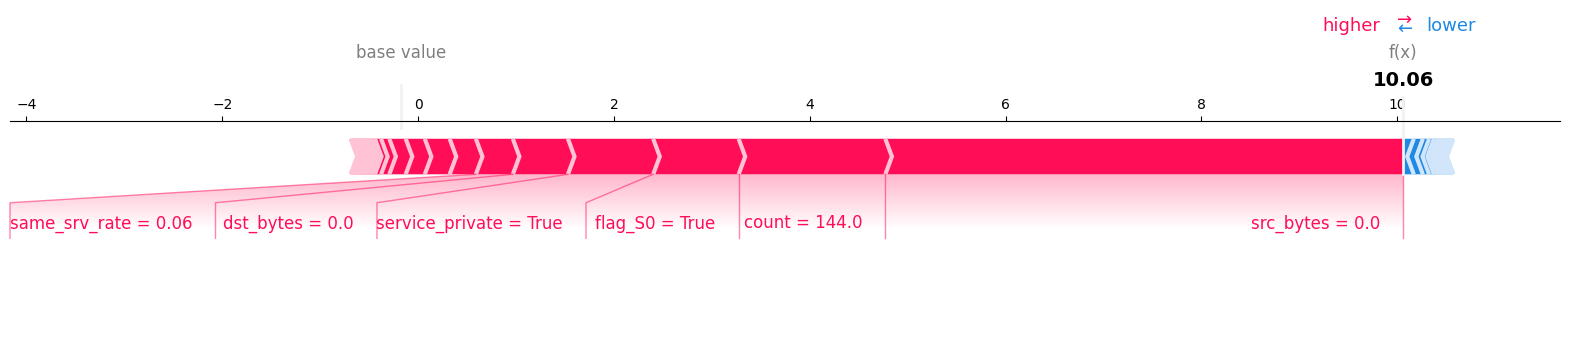

Generating SHAP Waterfall Plot for Instance 40...


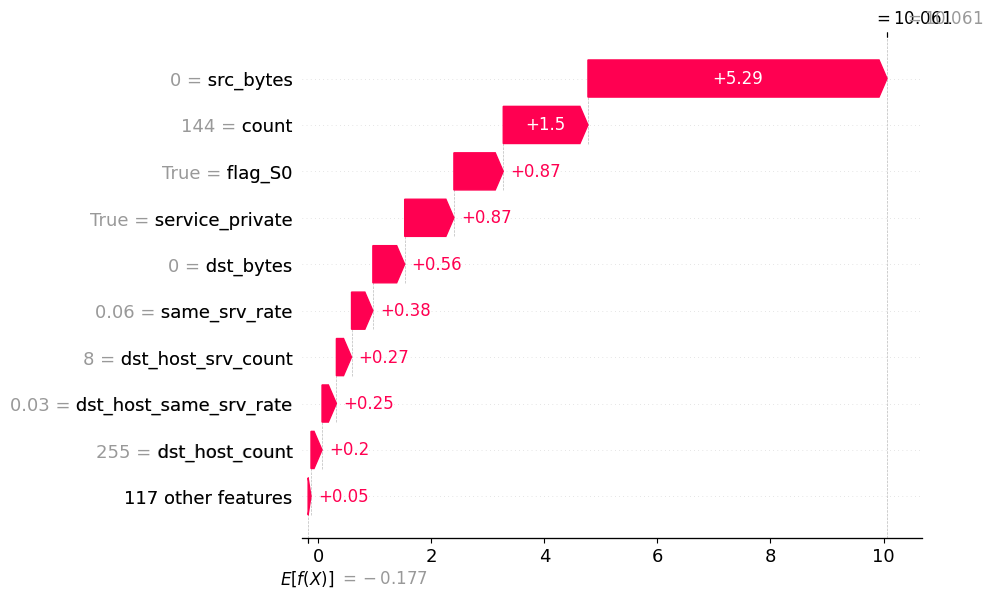

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(best_model)

def predict_instance(instance_index):
    """
    Function to predict and analyze a single instance from X_test using SHAP.
    
    Parameters:
    - instance_index: Index of the instance in X_test to analyze.
    """
    instance = X_test.iloc[instance_index:instance_index+1]
    
    prediction = best_model.predict(instance)[0]
    print(f"Prediction for instance {instance_index}: {'Anomaly' if prediction == 1 else 'Normal'}")
    
    if prediction == 1:
        attack_type = label_attack_type(test_df.iloc[instance_index])
        print(f"Identified Attack Type: {attack_type}")
    else:
        attack_type = 'Normal'
    
    # Calculate SHAP values for the instance
    shap_values = explainer.shap_values(instance)
    
    # Generate SHAP force plot for the instance
    print(f"Generating SHAP Force Plot for Instance {instance_index}...")
    shap.force_plot(explainer.expected_value, shap_values, instance, matplotlib=True)
    plt.show()
    
    # Generate SHAP waterfall plot for the instance
    print(f"Generating SHAP Waterfall Plot for Instance {instance_index}...")
    shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=instance.iloc[0]))
    plt.show()

predict_instance(40) 

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(best_model)

def get_top_features(shap_values, feature_names, top_n=5):
    shap_abs = pd.DataFrame(shap_values, columns=feature_names).abs()
    top_features = shap_abs.apply(lambda row: row.nlargest(top_n).index.tolist(), axis=1)
    return top_features

shap_values = explainer.shap_values(X_test)

top_features = get_top_features(shap_values, X_test.columns, top_n=5)

test_df['top_features'] = top_features

top_features_by_type = test_df.groupby('attack_type')['top_features'].apply(lambda x: x.explode().value_counts().head(5))

print("Top features by attack type:")
print(top_features_by_type)

top_features_by_type.to_csv("top_features_by_attack_type.csv")


Top features by attack type:
attack_type                           
Guess_password  src_bytes                  472
                count                      466
                dst_bytes                  460
                service_telnet             350
                dst_host_srv_count         315
Neptune         src_bytes                 1974
                count                     1832
                flag_S0                   1667
                dst_bytes                 1433
                service_private            926
Nmap            src_bytes                  170
                dst_bytes                  158
                count                      123
                dst_host_rerror_rate        90
                dst_host_diff_srv_rate      86
Other           src_bytes                 6608
                count                     5147
                dst_bytes                 3828
                dst_host_rerror_rate      3285
                dst_host_srv_count     